# Fully connected network with Mnist dataset

Copyright (C) Communications & Machine learning Laboratory, Seoul National University

# 1. Load & visualize the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

# You can use other modules if you want

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

# Download mnist data in ./data folder

In [3]:
# Make data to numpy array
train_image = trainset.data.numpy()
train_label = trainset.targets.numpy()

## Mnist data

MNIST is a simple computer vision dataset. It consists of a handwritten image, and it contains a label for each image that tells you what the number is. 

The downloaded data is divided into three parts: 60,000 training data (`trainset`) and 10,000 test data (`testset`). This division of data is very important. Because with test data, we can be sure that what we've learned is really generalized.

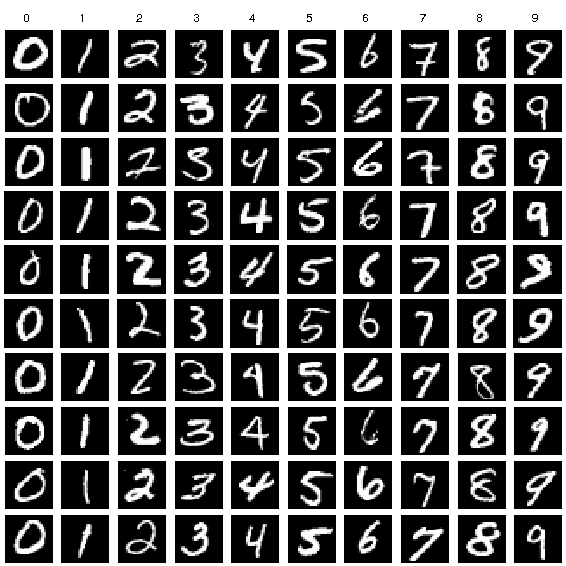

Each image in the data is 28x28 pixels. We can interpret this as a large array of numbers. We can expand this array and make it 28x28 = 784 vectors. It doesn't matter how you expand the array, as long as you process them consistently between the images. As a result of unfolding the data, image from `train_image` becomes a array of the form [`28,28`] to [`784`](flattened by Prob.4 code). 

At `train_image` [`60000,28,28`], the first dimension refers to the number of image and the second & third dimension refers to the size of each image. Every component in a tensor is a pixel intensity between 0 and 255 that identifies a particular pixel in a particular image.

In [4]:
print('Shape of train_image:', np.shape(train_image))
print('Shape of train_label:', np.shape(train_label))

Shape of train_image: (60000, 28, 28)
Shape of train_label: (60000,)


Each label in MNIST is a number between 0 and 9, telling you what number each image is. In this case, `train_label` is a real array of the same shape as [`60000, `].

You can see 2D-array looks like plotted image from below codes.

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  30  94 170 253 253 225 253 195   0   0]
 [  0   0   0   0 219 253 253 198 247   0   0   0   0   0]
 [  0   0   0   0   0   1 253   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 190  70   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 240 253  25   0   0   0   0]
 [  0   0   0   0   0   0   0   0  93 253   0   0   0   0]
 [  0   0   0   0   0   0   0  46 183 253   2   0   0   0]
 [  0   0   0   0   0  24 221 253 253  78   0   0   0   0]
 [  0   0   0  18 219 253 253  80   0   0   0   0   0   0]
 [  0   0 136 253 212 132   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


Text(0.5,1,'5')

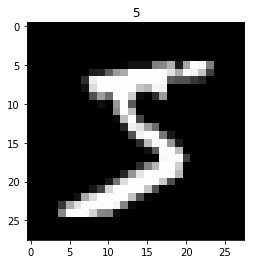

In [5]:
print(train_image[0][::2,::2])

plt.figure()
plt.imshow(train_image[0], cmap = 'gray')
plt.title(train_label[0])

### Problem 1

Now, let's see how images look like. Plot images from 0 to 9 with labels.

*Hint*: Find numbers from `train_label` with `for` and `==`.

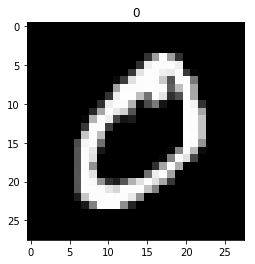

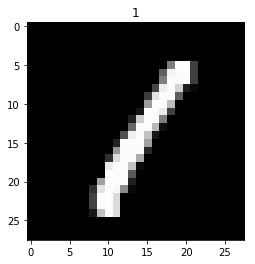

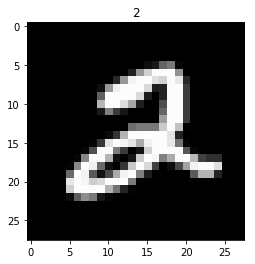

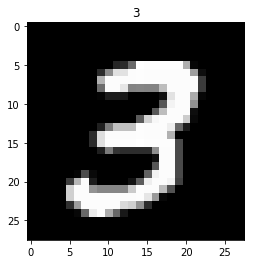

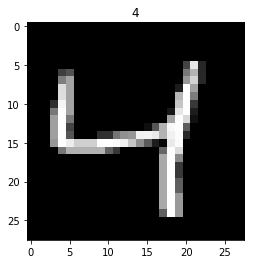

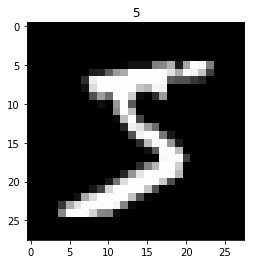

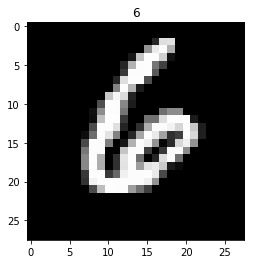

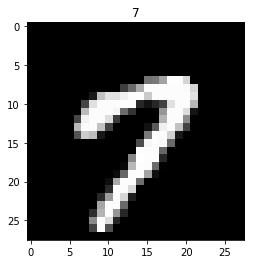

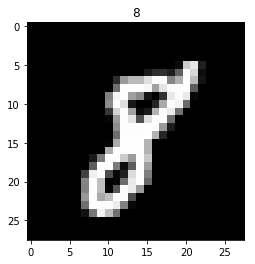

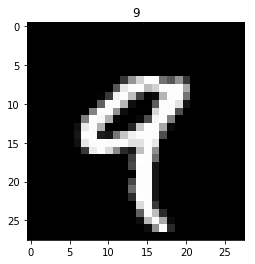

In [6]:
###################################################################################
#                                   YOUR CODE HERE                                #
###################################################################################

number_idx = np.zeros([10,1], dtype = int)

for i in range(0,10):
    current_idx = 0
    while(1):
        if(train_label[current_idx] == i):
            number_idx[i] = current_idx
            break
        current_idx = current_idx + 1
    plt.figure(i)
    plt.imshow(np.squeeze(train_image[number_idx[i]]), cmap = 'gray')
    plt.title(i)
            
###################################################################################
#                                  END OF YOUR CODE                               #
###################################################################################

# 2. Fully connected network without tensorflow

Building fully connected model without tensorflow is little bit difficult, so we will do simple backpropagation. You can see `ch3` for more informations.

In [7]:
#These codes are for Prob2, 3

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

## Forward propagation

Calculate the output from the input training data and calculate the error in each ouput neuron. (It is called ‘forward’ propagation because information flows to input-> hidden-> output.) This is much easier than back propagation. 

### Problem 2

Fill the function `affine_forward` and `relu_forward` with your code. *Hint:* Check `ch3`

In [8]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    ###################################################################################
    #                                   YOUR CODE HERE                                #
    ###################################################################################
    x_reshaped = np.reshape(x, (np.shape(x)[0],-1))
    out = np.matmul(x_reshaped,w) + b
    ###################################################################################
    #                                  END OF YOUR CODE                               #
    ###################################################################################
    cache = (x, w, b)
    return out, cache

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    ###################################################################################
    #                                   YOUR CODE HERE                                #
    ###################################################################################
    zeros = np.zeros(np.shape(x))
    out = np.maximum(zeros,x)
    ###################################################################################
    #                                  END OF YOUR CODE                               #
    ###################################################################################
    cache = x
    return out, cache

Test codes are below

In [9]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


In [10]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


## Back propagation

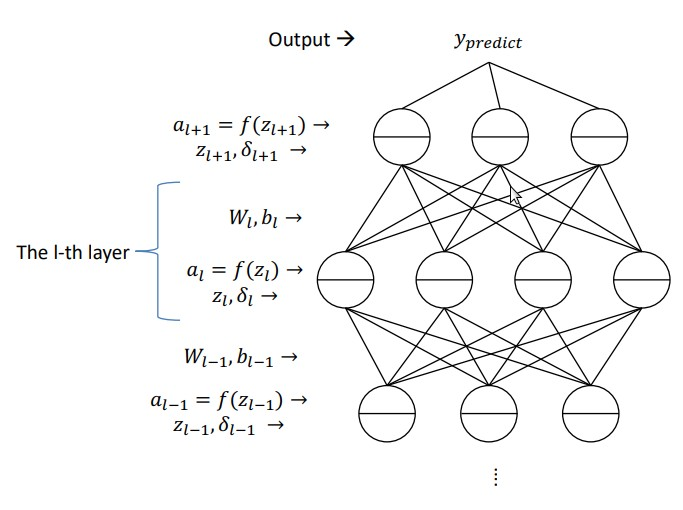

Backpropagation is a method of calculating gradients by applying a repetitive chain rule for the entire network. Let's look more specifically at the neural network perspective on why we are interested in this issue.

For example, the loss function can be the SVM Loss function, and the input values are training data $(x_i, y_i), i = 1... N$ and Weight, Bias $W, b$. Here, the learning data can be seen as a fixed value, and Weight is the value that is actually controlled for the neural network learning. Therefore, although the gradient calculation for the input value $x_i$ is easy, in practice, the gradient for the parameter value is generally calculated, and the parameter value can be used to update the gradient.

At the image, you can compute $σ_l$(the backpropagated loss function($L$)) with value $z_l$, $σ_{l+1}$ and weight $w$. Then you can use these $σ$ with gradient descent to update weight $w$.

### Problem 3

Fill the function `affine_backward` and `relu_backward` with your code. *Hint:* Check `ch3`

In [11]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    ###################################################################################
    #                                   YOUR CODE HERE                                #
    ###################################################################################
    dx = np.reshape(np.matmul(dout,np.transpose(w)), np.shape(x))
    dw = np.matmul(np.transpose(np.reshape(x,(np.shape(x)[0],-1))),dout)
    db = np.sum(dout, axis = 0)
    ###################################################################################
    #                                  END OF YOUR CODE                               #
    ###################################################################################
    
    return dx, dw, db

def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    x = cache
    ###################################################################################
    #                                   YOUR CODE HERE                                #
    ###################################################################################
    dx = np.array(x>0, dtype=float)*dout
    ###################################################################################
    #                                  END OF YOUR CODE                               #
    ###################################################################################
    return dx

Test codes are below

In [12]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)
# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


In [13]:
# Test the relu_backward function
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# 3. Fully connected network with tensorflow

In Pytorch, we will make model with nn.Module

In [14]:
class FC_model(nn.Module):
    def __init__(self):
        super(FC_model, self).__init__()
        fc1 = nn.Linear(28*28, 100)
        fc2 = nn.Linear(100,10)
        
        self.fc_module = nn.Sequential(
            nn.Flatten(), fc1, nn.ReLU(), fc2     
        )
        
    def forward(self, x):
        out = self.fc_module(x)
        return out

Pytorch supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, loss functions, activations : https://pytorch.org/docs/stable/nn.html
* Optimizers: https://pytorch.org/docs/stable/optim.html

In [15]:
# Write your model name here
model = FC_model()

# You can change criterion, optimizer, num_epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 5

# This is for training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total = 0
    correct = 0
    print('\nEpoch: %d' % (epoch+1))
    for batch_idx, data in enumerate(trainloader):
        image, label = data
        # Grad initialization
        optimizer.zero_grad()
        # Forward propagation
        output = model(image)
        # Calculate loss
        loss = criterion(output, label)
        # Backprop
        loss.backward()
        # Weight update
        optimizer.step()
        
        train_loss += loss.item()
        _,predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
        
        if (batch_idx+1) % 1000 == 0:
            print("Step: {}/{} | train_loss: {:.4f} | Acc:{:.3f}%".format(batch_idx+1, len(trainloader), train_loss/1000, 100.*correct/total))

print("--------------------------------------------------")            
print("--------------------Test data---------------------")            
print("--------------------------------------------------")            
            
# This is for test data
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        image, label = data
        output = model(image)
        loss = criterion(output, label)
        
        test_loss += loss.item()
        _,predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
        
        if (batch_idx+1) == len(testloader):
            print("Test_loss: {:.4f} | Test_Acc:{:.3f}%".format(test_loss/1000, 100.*correct/total))



Epoch: 1
Step: 1000/6000 | train_loss: 1.1936 | Acc:72.650%
Step: 2000/6000 | train_loss: 1.6826 | Acc:79.840%
Step: 3000/6000 | train_loss: 2.0724 | Acc:83.087%
Step: 4000/6000 | train_loss: 2.4364 | Acc:84.735%
Step: 5000/6000 | train_loss: 2.7702 | Acc:85.872%
Step: 6000/6000 | train_loss: 3.0856 | Acc:86.683%

Epoch: 2
Step: 1000/6000 | train_loss: 0.2958 | Acc:91.530%
Step: 2000/6000 | train_loss: 0.5839 | Acc:91.600%
Step: 3000/6000 | train_loss: 0.8508 | Acc:91.817%
Step: 4000/6000 | train_loss: 1.1103 | Acc:91.987%
Step: 5000/6000 | train_loss: 1.3613 | Acc:92.156%
Step: 6000/6000 | train_loss: 1.6019 | Acc:92.340%

Epoch: 3
Step: 1000/6000 | train_loss: 0.2262 | Acc:93.380%
Step: 2000/6000 | train_loss: 0.4389 | Acc:93.625%
Step: 3000/6000 | train_loss: 0.6550 | Acc:93.757%
Step: 4000/6000 | train_loss: 0.8780 | Acc:93.698%
Step: 5000/6000 | train_loss: 1.0861 | Acc:93.734%
Step: 6000/6000 | train_loss: 1.2809 | Acc:93.888%

Epoch: 4
Step: 1000/6000 | train_loss: 0.1935 | Acc

### Problem 4

Make test accuracy greater than 0.97 with your own model. You can change architectures, hyperparameters, loss functions, and optimizers. Also, you can use dropout or batchnorm.

After you make your own model, check your model with upper codes.

*Hint:* Use upper codes

In [16]:
###################################################################################
#                                   YOUR CODE HERE                                #
###################################################################################
class FC_user_model(nn.Module):
    def __init__(self):
        super(FC_user_model, self).__init__()
        fc1 = nn.Linear(28*28, 200)
        fc2 = nn.Linear(200, 100)
        fc3 = nn.Linear(100,10)
        
        self.fc_module = nn.Sequential(
            nn.Flatten(), fc1, nn.ReLU(), fc2, nn.ReLU(), fc3     
        )
        
    def forward(self, x):
        out = self.fc_module(x)
        return out
    
# Write your model name here
model = FC_user_model()

# You can change criterion, optimizer, num_epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 10

# This is for training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total = 0
    correct = 0
    print('\nEpoch: %d' % (epoch+1))
    for batch_idx, data in enumerate(trainloader):
        image, label = data
        # Grad initialization
        optimizer.zero_grad()
        # Forward propagation
        output = model(image)
        # Calculate loss
        loss = criterion(output, label)
        # Backprop
        loss.backward()
        # Weight update
        optimizer.step()
        
        train_loss += loss.item()
        _,predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
        
        if (batch_idx+1) % 1000 == 0:
            print("Step: {}/{} | train_loss: {:.4f} | Acc:{:.3f}%".format(batch_idx+1, len(trainloader), train_loss/1000, 100.*correct/total))

print("--------------------------------------------------")            
print("--------------------Test data---------------------")            
print("--------------------------------------------------")            
            
# This is for test data
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        image, label = data
        output = model(image)
        loss = criterion(output, label)
        
        test_loss += loss.item()
        _,predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
        
        if (batch_idx+1) == len(testloader):
            print("Test_loss: {:.4f} | Test_Acc:{:.3f}%".format(test_loss/1000, 100.*correct/total))

###################################################################################
#                                  END OF YOUR CODE                               #
###################################################################################


Epoch: 1
Step: 1000/6000 | train_loss: 1.6318 | Acc:59.030%
Step: 2000/6000 | train_loss: 2.1759 | Acc:72.105%
Step: 3000/6000 | train_loss: 2.5838 | Acc:77.377%
Step: 4000/6000 | train_loss: 2.9461 | Acc:80.427%
Step: 5000/6000 | train_loss: 3.2661 | Acc:82.518%
Step: 6000/6000 | train_loss: 3.5674 | Acc:83.982%

Epoch: 2
Step: 1000/6000 | train_loss: 0.2694 | Acc:92.240%
Step: 2000/6000 | train_loss: 0.5403 | Acc:92.035%
Step: 3000/6000 | train_loss: 0.7864 | Acc:92.330%
Step: 4000/6000 | train_loss: 1.0203 | Acc:92.525%
Step: 5000/6000 | train_loss: 1.2337 | Acc:92.770%
Step: 6000/6000 | train_loss: 1.4492 | Acc:92.925%

Epoch: 3
Step: 1000/6000 | train_loss: 0.1973 | Acc:94.200%
Step: 2000/6000 | train_loss: 0.3839 | Acc:94.310%
Step: 3000/6000 | train_loss: 0.5691 | Acc:94.420%
Step: 4000/6000 | train_loss: 0.7467 | Acc:94.582%
Step: 5000/6000 | train_loss: 0.8991 | Acc:94.740%
Step: 6000/6000 | train_loss: 1.0459 | Acc:94.915%

Epoch: 4
Step: 1000/6000 | train_loss: 0.1472 | Acc

### Submission
- Submit a zip file named as ‘hw2_StudentID.zip’ on etl
- Zip file must contain only one ipynb file ‘Homework2_torch.ipynb’
- Hard copy is not required